In [1]:
import cloudscraper
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection & Preparation

In [2]:
scraper = cloudscraper.create_scraper() 

collection_id = '1451b80cbf65fb6dd796dd094d3a94bf7d2d4e759181ea2b0fa479b69e9c73e7'
url = f"https://api.solscan.io/collection/trade?collectionId={collection_id}&offset=0&limit=90000"

response = scraper.get(url)
# response.json()

In [3]:
data = pd.DataFrame(response.json()['data'])
data = data[['price', 'tradeTime']]

In [4]:
# Convert Unix timestamp to date & add it to the dataframe

dates = []
for i in range(len(data.index)):
    dates.append(datetime.fromtimestamp(data.loc[i]['tradeTime']).strftime('%Y-%m-%d'))

data['date'] = pd.to_datetime(dates)

In [5]:
# Preparing the num of sales data

start = data.date.min()
end = data.date.max()

index = pd.date_range(start, end, freq='D')
columns = ['Sales']
sales = pd.DataFrame(index=index, columns=columns)

sales_with_missing_days = data.groupby('date').date.count()

for index, value in sales_with_missing_days.items():
    sales.loc[index] = value
sales['Time'] = np.arange(len(sales.index))
sales['Sales'] = sales.Sales.fillna(0)

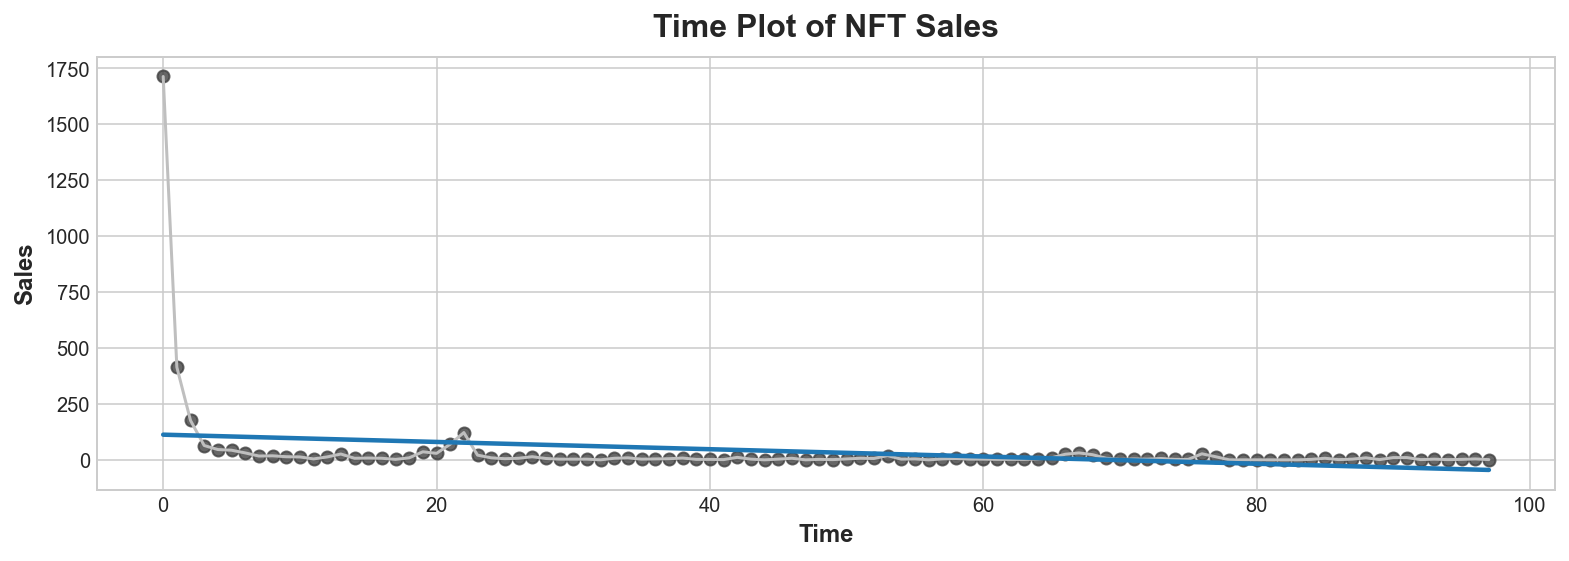

In [10]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Sales', data=sales, color='0.75')
ax = sns.regplot(x='Time', y='Sales', data=sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of NFT Sales');

# Sales usually reach thier peak in the release date then drop 

In [6]:
# Floor price data

start = data.date.min()
end = data.date.max() 


index = pd.date_range(start, end, freq='D')
columns = ['Fprice']
fprice = pd.DataFrame(index=index, columns=columns)

fprice_with_missing_days = data.groupby('date').price.min()

for index, value in fprice_with_missing_days.items():
    fprice.loc[index] = value
fprice['Time'] = np.arange(len(sales.index))
fprice['Fprice'] = fprice.Fprice.fillna(fprice.Fprice.mean())

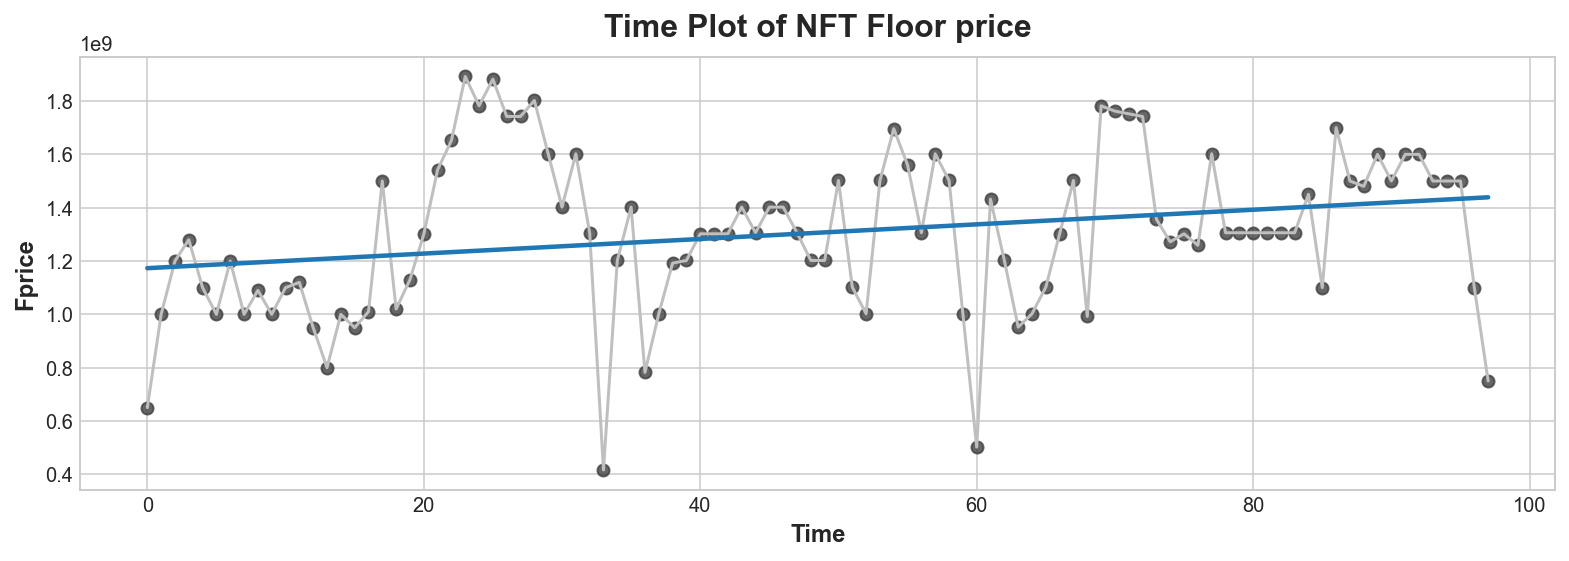

In [12]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Fprice', data=fprice, color='0.75')
ax = sns.regplot(x='Time', y='Fprice', data=fprice, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of NFT Floor price');

In [ ]:
# Max price 


In [6]:
# Avg price data

start = data.date.min()
end = data.date.max() 


index = pd.date_range(start, end, freq='D')
columns = ['avg. price']
complete_avg_price = pd.DataFrame(index=index, columns=columns)

recorded_avg_price = data.groupby('date').price.mean()

for index, value in recorded_avg_price.items():
    complete_avg_price.loc[index] = value
complete_avg_price['Time'] = np.arange(len(sales.index))
complete_avg_price['avg. price'] = complete_avg_price['avg. price'].fillna(complete_avg_price['avg. price'].mean())

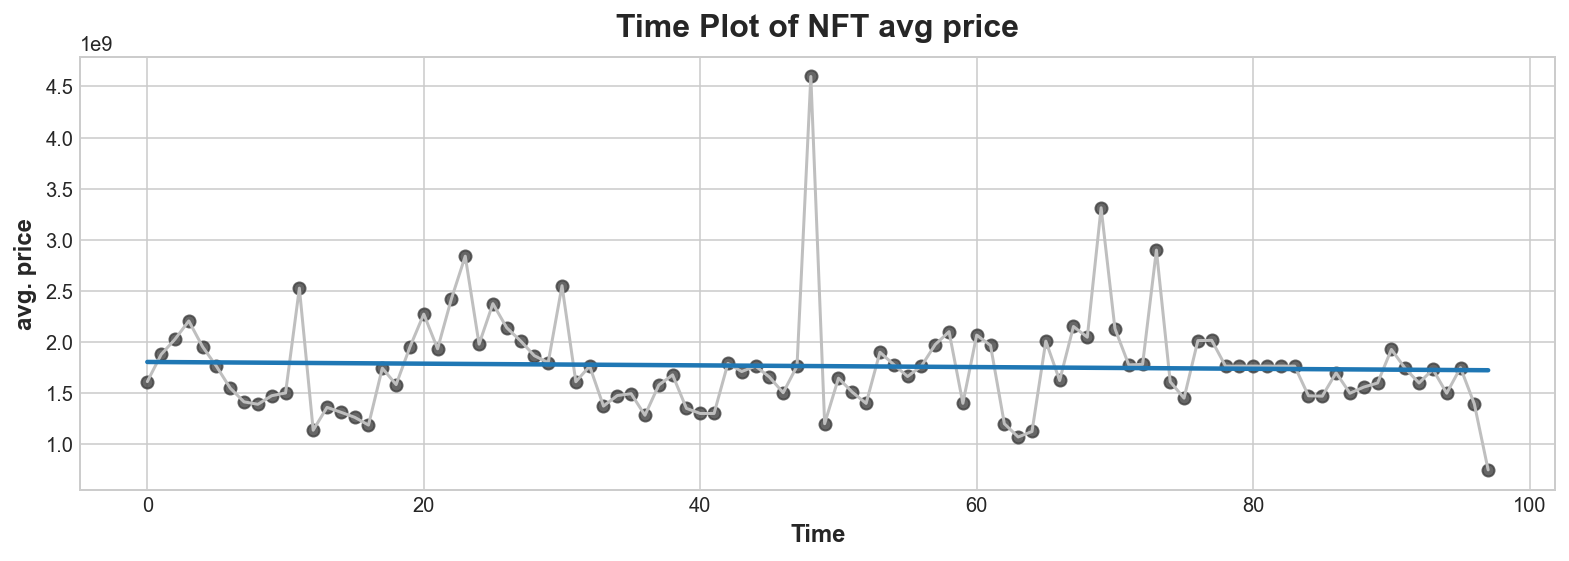

In [14]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'avg. price', data=complete_avg_price, color='0.75')
ax = sns.regplot(x='Time', y='avg. price', data=complete_avg_price, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of NFT avg price');

# Modeling

## ARIMA 

In [19]:
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# Train test split 

to_row = int(len(complete_avg_price)*0.9)

training_data = list(complete_avg_price[0:to_row]['avg. price'])
testing_data = list(complete_avg_price[to_row:]['avg. price'])

testing_data

[1560000000.0,
 1600000000.0,
 1928000000.0,
 1742000000.0,
 1600000000.0,
 1733333333.3333333,
 1500000000.0,
 1750000000.0,
 1395000000.0,
 750000000.0]

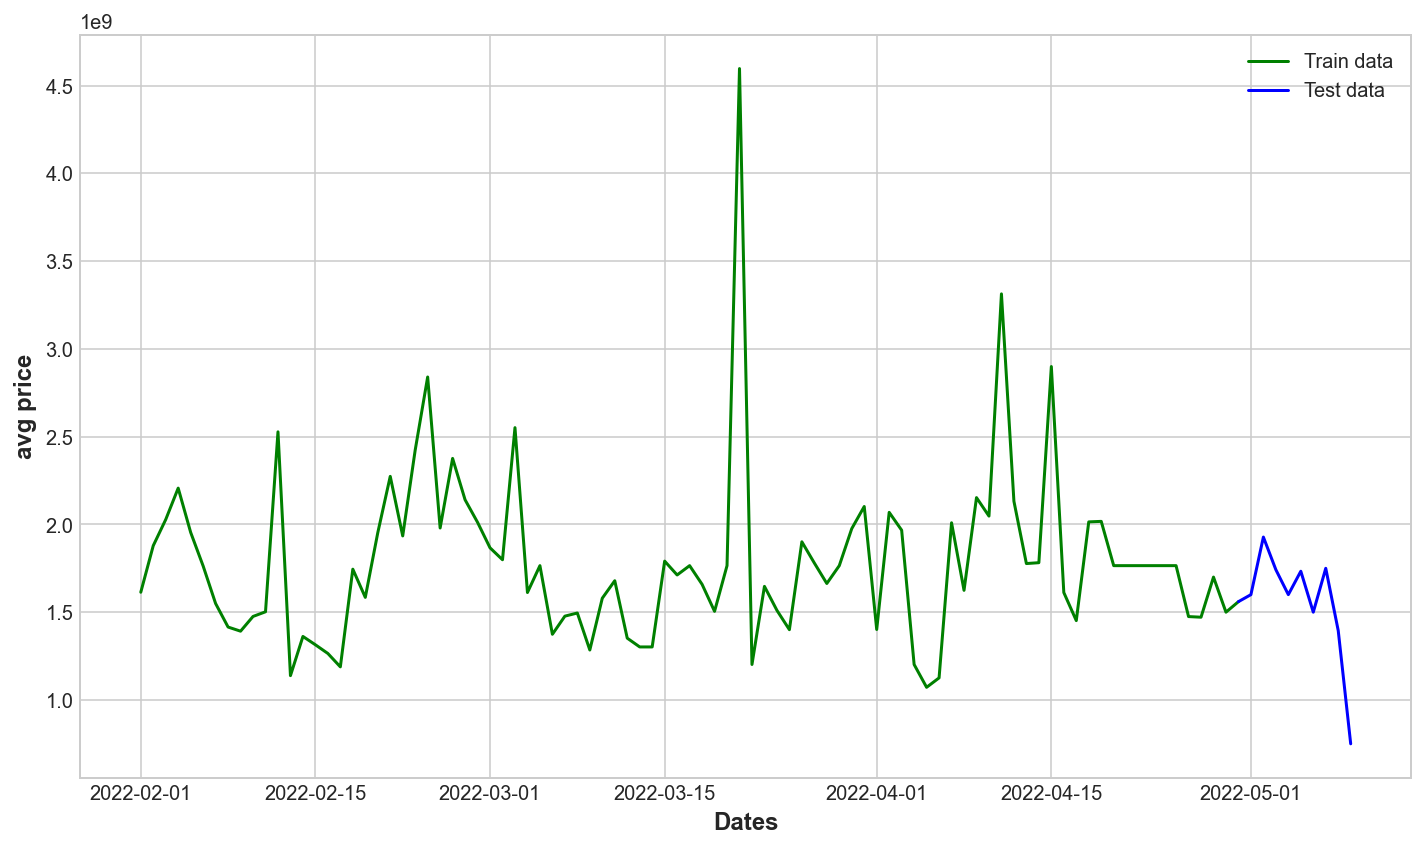

In [21]:
# Split data into train and testing sets
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('avg price')
plt.plot(complete_avg_price[0:to_row+1]['avg. price'], 'green', label='Train data')
plt.plot(complete_avg_price[to_row:]['avg. price'], 'blue', label='Test data')
plt.legend()

In [22]:
model_predictions = []
n_test_obser = len(testing_data)

In [23]:
for i in range(n_test_obser):
    model = ARIMA(training_data, order = (4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

In [20]:
# model_fit.summary()

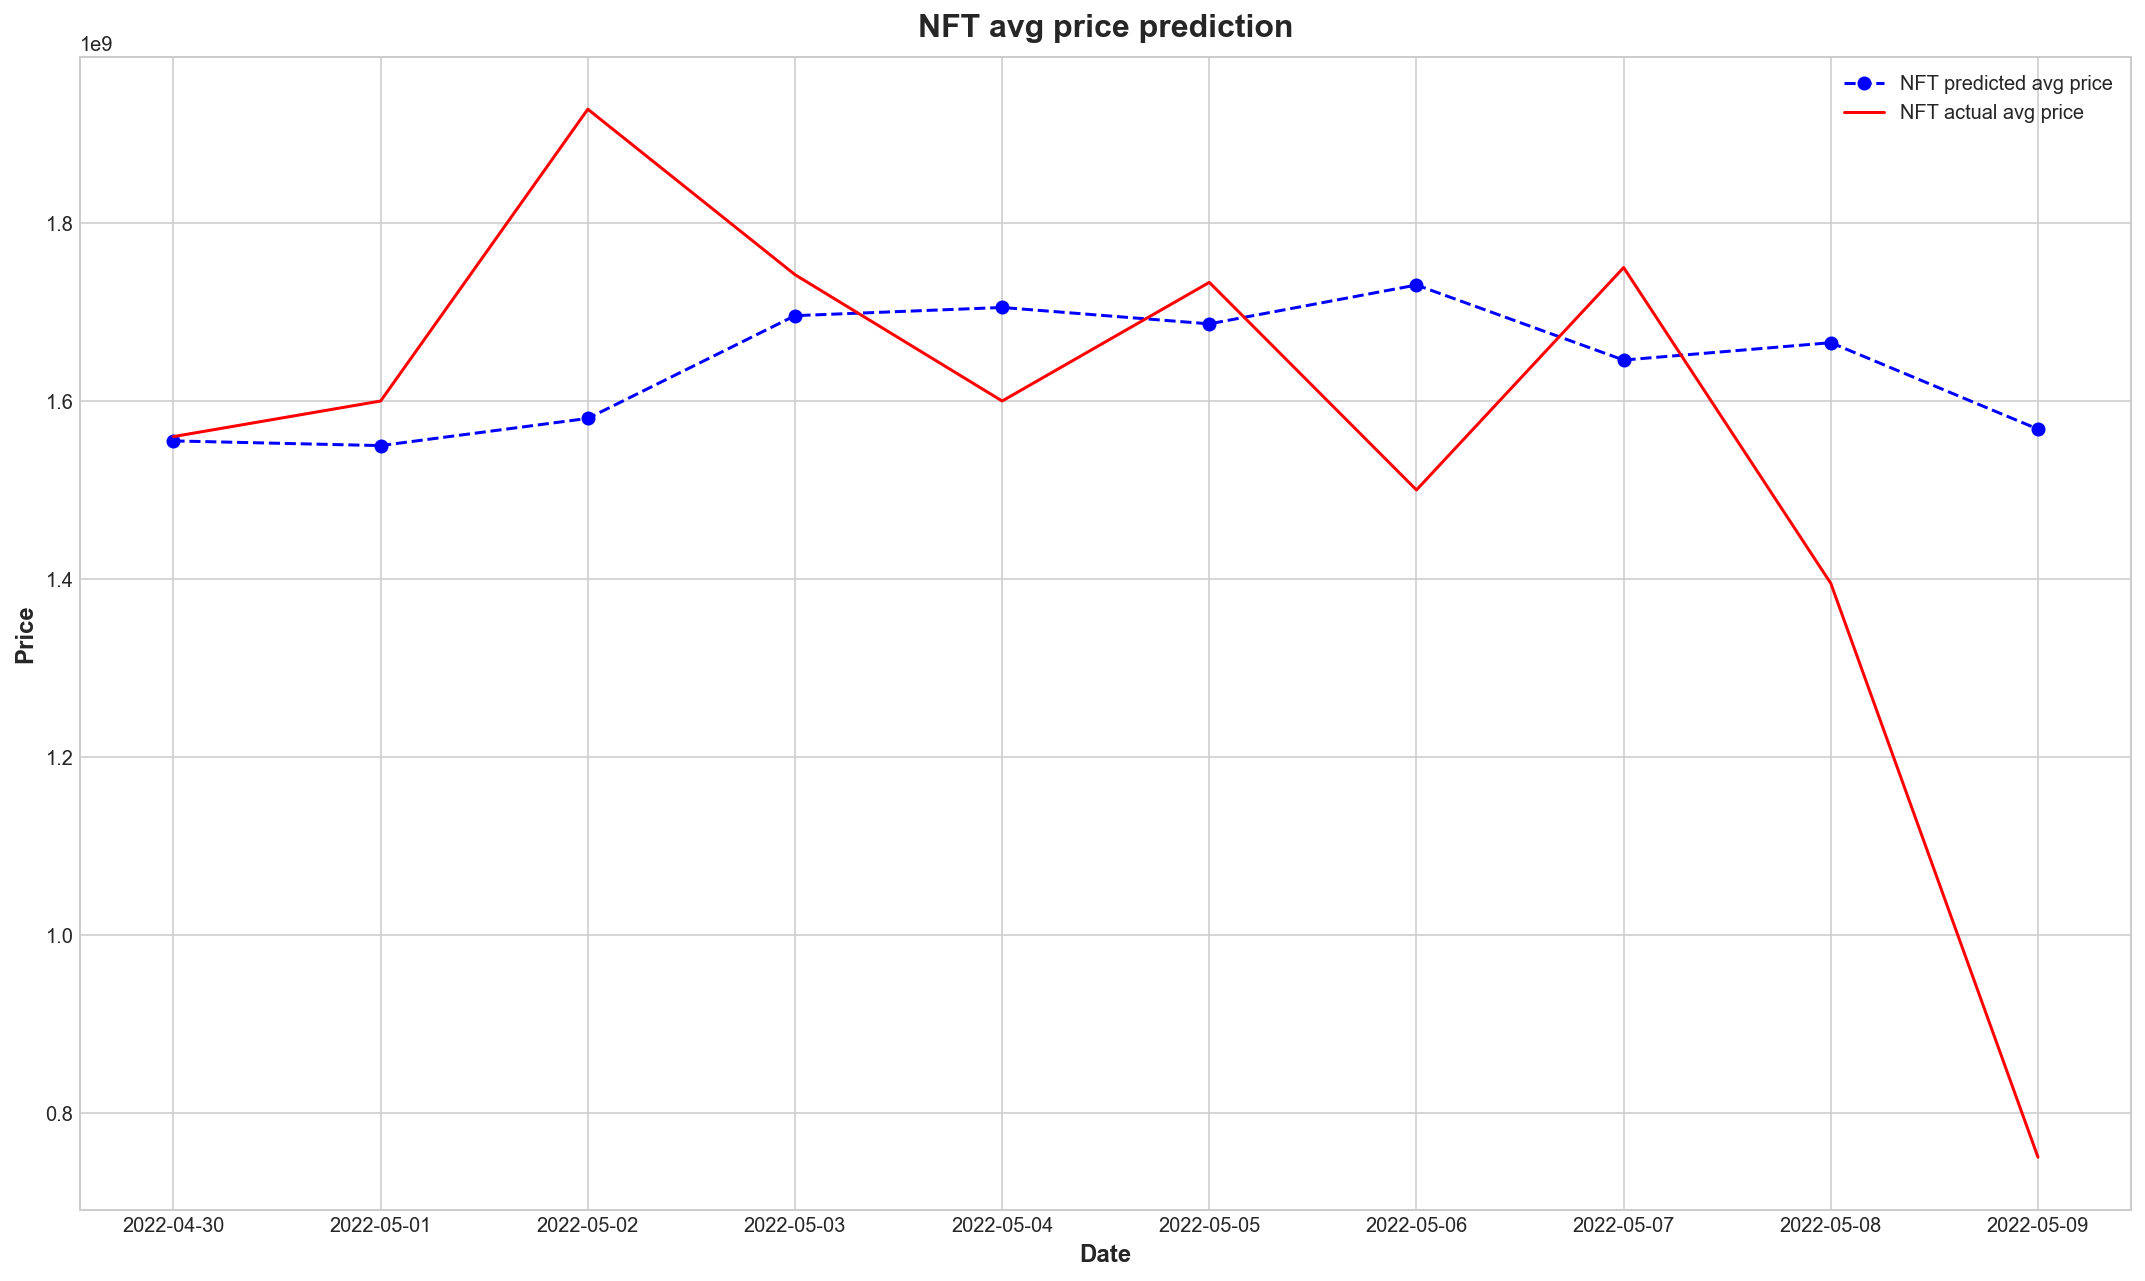

In [24]:
plt.figure(figsize=(15,9))
plt.grid(True)

date_range = complete_avg_price[to_row:].index

plt.plot(date_range, model_predictions[:], color = 'blue', marker = 'o', linestyle = 'dashed', label = 'NFT predicted avg price')
plt.plot(date_range, testing_data, color = 'red', label = 'NFT actual avg price')

plt.title('NFT avg price prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
mape = np.mean(np.abs(np.array(model_predictions[:]) - np.array(testing_data))/np.abs(testing_data))
print('MAPE:' + str(mape)) #Mean Absolute Percentage error

# Around 19.79% MAPE implies the model is about 80.21% accurate in predicting the test set observations.

MAPE:0.183192838915527


## Prophet 

In [7]:
from prophet import Prophet

In [8]:
df = complete_avg_price
df.reset_index(inplace = True)
df.drop('Time',  axis=1, inplace=True)

In [9]:
df.columns = ['ds', 'y']

In [56]:
df

,ds,y
0,2022-02-01,1.613512e+09
1,2022-02-02,1.878774e+09
2,2022-02-03,2.027772e+09
3,2022-02-04,2.206714e+09
4,2022-02-05,1.954543e+09
...,...,...
93,2022-05-05,1.733333e+09
94,2022-05-06,1.500000e+09
95,2022-05-07,1.750000e+09
96,2022-05-08,1.395000e+09


In [10]:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\aouiniou\anaconda3\envs\nftpp\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [12]:
model.component_modes

{'additive': ['weekly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [15]:
df.tail()

,ds,y
93,2022-05-05,1.733333e+09
94,2022-05-06,1.500000e+09
95,2022-05-07,1.750000e+09
96,2022-05-08,1.395000e+09
97,2022-05-09,7.500000e+08


In [11]:
future_dates = model.make_future_dataframe(periods= 7)

In [17]:
future_dates.tail()

,ds
100,2022-05-12
101,2022-05-13
102,2022-05-14
103,2022-05-15
104,2022-05-16


In [12]:
prediction = model.predict(future_dates)

C:\Users\aouiniou\anaconda3\envs\nftpp\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\aouiniou\anaconda3\envs\nftpp\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [66]:
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
100,2022-05-12,1.713616e+09,1.159283e+09,2.444007e+09,1.713616e+09,1.713617e+09,9.316692e+07,9.316692e+07,9.316692e+07,9.316692e+07,9.316692e+07,9.316692e+07,0.0,0.0,0.0,1.806783e+09
101,2022-05-13,1.712614e+09,1.046188e+09,2.272889e+09,1.712613e+09,1.712614e+09,-1.697296e+07,-1.697296e+07,-1.697296e+07,-1.697296e+07,-1.697296e+07,-1.697296e+07,0.0,0.0,0.0,1.695641e+09
102,2022-05-14,1.711611e+09,1.212888e+09,2.397211e+09,1.711611e+09,1.711612e+09,8.400997e+07,8.400997e+07,8.400997e+07,8.400997e+07,8.400997e+07,8.400997e+07,0.0,0.0,0.0,1.795621e+09
103,2022-05-15,1.710609e+09,9.755690e+08,2.204270e+09,1.710608e+09,1.710610e+09,-8.865800e+07,-8.865800e+07,-8.865800e+07,-8.865800e+07,-8.865800e+07,-8.865800e+07,0.0,0.0,0.0,1.621951e+09
104,2022-05-16,1.709606e+09,1.307283e+09,2.477467e+09,1.709605e+09,1.709607e+09,1.814458e+08,1.814458e+08,1.814458e+08,1.814458e+08,1.814458e+08,1.814458e+08,0.0,0.0,0.0,1.891052e+09


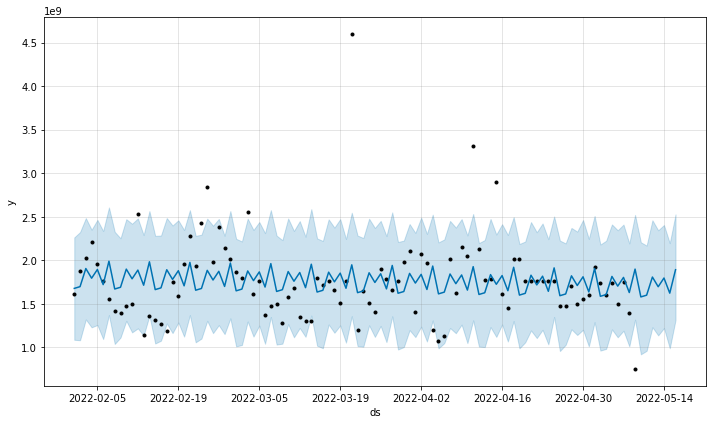

In [13]:
fig = model.plot(prediction)

In [ ]:
from prophet.plot import plot_plotly
plot_plotly(model, prediction)

C:\Users\aouiniou\anaconda3\envs\nftpp\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



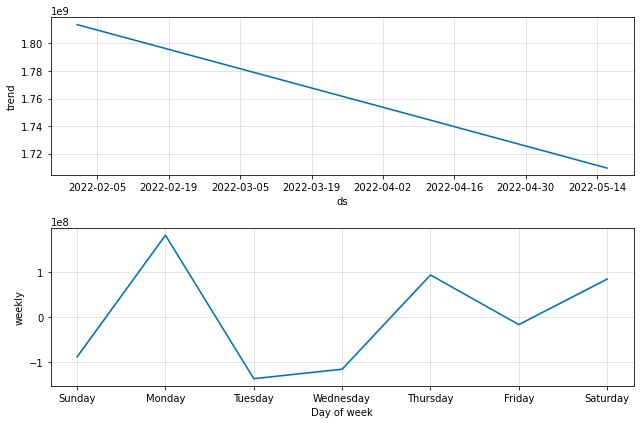

In [16]:
fig2 = model.plot_components(prediction)

In [19]:
from prophet.diagnostics import cross_validation

In [ ]:
df_cv = cross_validation(model, horizon = '7 days')

In [24]:
from prophet.diagnostics import performance_metrics

In [25]:
df_performance = performance_metrics(df_cv)

In [26]:
df_performance 

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 00:00:00.000000007,3.207693e+17,5.663649e+08,3.883133e+08,0.223753,0.171001,0.214429,0.722222


## LSTM 

In [32]:
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.layers import Dense, Dropout, LSTM
# from tensorflow.keras.models import Sequential 

In [34]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(complete_avg_price['avg. price'].values.reshape(-1,1))

In [40]:
scaled_data.shape

(98, 1)